In [1]:
from os import environ
from sklearn.metrics import classification_report

environ['optimizer'] = 'Adam'
environ['num_workers']= '4'
environ['batch_size']= '8192'
environ['n_epochs']= '1500'
environ['batch_norm']= 'True'
environ['loss_func']='BCE'
environ['layers'] = '600 350 200 180'
environ['dropouts'] = '0.3 '*4
environ['log'] = 'False'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:0'
environ['dataset'] = '/data/scratch/mmerouani/data/speedup_dataset_research_batch1001-2500.pkl'

%run utils.ipynb

In [ ]:
print("loading data")

# train_dl, val_dl, test_dl = train_dev_split(dataset,val_size=10000, test_size=10000, batch_size=batch_size, num_workers=num_workers, log=log)
threshold = 0.2
print(f"threshold= {threshold}")
def set_labels(Y):
    return (Y > threshold).astype('float32')
train_dl, val_dl, test_dl = train_dev_split_transform(dataset,val_size=10000, test_size=10000, batch_size=batch_size, num_workers=num_workers, log=log,
                                                     filter_func=None, transform_func=set_labels)
db = fai.basic_data.DataBunch(train_dl, val_dl, test_dl, device=device)

print("data loaded")
print(val_dl.dataset.X.shape)

In [8]:
print(val_dl.dataset.Y[5050])

[1.]


In [4]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]

model = None 

model = Classifier_Model_BN_ELU(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)

criterion=bce_criterion

l = fai.basic_train.Learner(db, model, loss_func=criterion, metrics=[criterion],
               callback_fns=[partial(EarlyStoppingCallback, mode='min', monitor='valid_loss', min_delta=0, patience=150)],silent=True)

if optimizer == 'SGD':
    l.opt_func = optim.SGD 
    

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


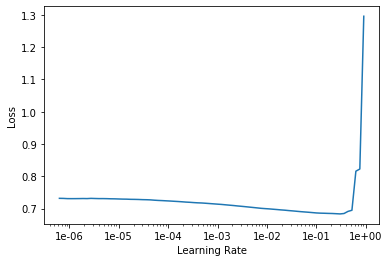

In [5]:
l.lr_find()
l.recorder.plot()

In [6]:
lr = 1e-03

In [7]:
l.fit_one_cycle(1500, lr)

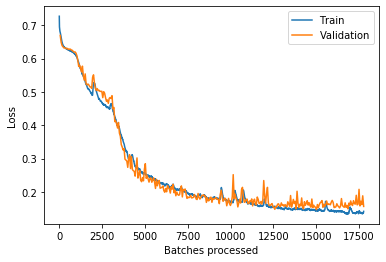

In [9]:
l.recorder.plot_losses()

In [17]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}_batch1001-2500_ELU_classif0.2")

In [35]:
val_df = get_results_df_classif(val_dl, l.model)
train_df = get_results_df_classif(train_dl, l.model)
test_df=get_results_df_classif(test_dl, l.model)

In [36]:
test_df.describe()

,index,prediction,target,speedup,abs_diff,BCELoss,interchange,tile,unroll
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,4999.50000,0.587596,0.583100,0.438427,0.079464,1.552090e-01,0.757900,0.940400,0.750000
std,2886.89568,0.455354,0.493082,0.384616,0.195332,1.954090e-14,0.428376,0.236756,0.433034
min,0.00000,0.000001,0.000000,0.004559,0.000001,1.552090e-01,0.000000,0.000000,0.000000
25%,2499.75000,0.007076,0.000000,0.086719,0.000085,1.552090e-01,1.000000,1.000000,0.750000
50%,4999.50000,0.913158,1.000000,0.309265,0.001002,1.552090e-01,1.000000,1.000000,1.000000
75%,7499.25000,0.999730,1.000000,0.775881,0.028104,1.552090e-01,1.000000,1.000000,1.000000
max,9999.00000,0.999999,1.000000,2.645030,0.999848,1.552090e-01,1.000000,1.000000,1.000000


In [37]:
val_df.describe()

,index,prediction,target,speedup,abs_diff,BCELoss,interchange,tile,unroll
count,10000.00000,1.000000e+04,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,14999.50000,6.021708e-01,0.613200,0.434748,5.877157e-02,1.092922e-01,0.782900,0.947300,0.750000
std,2886.89568,4.620973e-01,0.487047,0.526266,1.711004e-01,1.293474e-14,0.412292,0.223445,0.433034
min,10000.00000,7.556801e-07,0.000000,0.004063,2.384186e-07,1.092922e-01,0.000000,0.000000,0.000000
25%,12499.75000,3.441892e-03,0.000000,0.088260,4.777312e-05,1.092922e-01,1.000000,1.000000,0.750000
50%,14999.50000,9.715464e-01,1.000000,0.323237,4.986991e-04,1.092922e-01,1.000000,1.000000,1.000000
75%,17499.25000,9.998292e-01,1.000000,0.683457,9.279191e-03,1.092922e-01,1.000000,1.000000,1.000000
max,19999.00000,9.999998e-01,1.000000,6.865816,9.995855e-01,1.092922e-01,1.000000,1.000000,1.000000


In [38]:
train_df.describe()

,index,prediction,target,speedup,abs_diff,BCELoss,interchange,tile,unroll
count,438876.000000,4.388760e+05,438876.000000,438876.000000,4.388760e+05,4.388760e+05,438876.000000,438876.000000,438876.000000
mean,239437.500000,5.950569e-01,0.591290,0.417869,5.254563e-02,8.340904e-02,0.770386,0.943353,0.750000
std,126692.732707,4.624280e-01,0.491706,0.450577,1.506825e-01,4.088540e-13,0.420585,0.231167,0.433013
min,20000.000000,1.216148e-07,0.000000,0.002826,1.216148e-07,8.340904e-02,0.000000,0.000000,0.000000
25%,129718.750000,3.437403e-03,0.000000,0.089580,4.446507e-05,8.340904e-02,1.000000,1.000000,0.750000
50%,239437.500000,9.678116e-01,1.000000,0.317024,4.407763e-04,8.340904e-02,1.000000,1.000000,1.000000
75%,349156.250000,9.998361e-01,1.000000,0.707023,1.071711e-02,8.340904e-02,1.000000,1.000000,1.000000
max,458875.000000,9.999998e-01,1.000000,26.579260,9.994106e-01,8.340904e-02,1.000000,1.000000,1.000000


In [39]:
a = 0.5
tn_t=test_df[(test_df['target']<=a) & (test_df['prediction']<=a)][['target','prediction']]
tp_t=test_df[(test_df['target']>=a) & (test_df['prediction']>=a)][['target','prediction']]
fn_t=test_df[(test_df['target']>=a) & (test_df['prediction']<=a)][['target','prediction']]
fp_t=test_df[(test_df['target']<=a) & (test_df['prediction']>=a)][['target','prediction']]
vfn_t=test_df[(test_df['speedup']>1) & (test_df['prediction']<=a)][['target','prediction']]

tn_v=val_df[(val_df['target']<=a) & (val_df['prediction']<=a)][['target','prediction']]
tp_v=val_df[(val_df['target']>=a) & (val_df['prediction']>=a)][['target','prediction']]
fn_v=val_df[(val_df['target']>=a) & (val_df['prediction']<=a)][['target','prediction']]
fp_v=val_df[(val_df['target']<=a) & (val_df['prediction']>=a)][['target','prediction']]
vfn_v=val_df[(val_df['speedup']>1) & (val_df['prediction']<=a)][['target','prediction']]

In [44]:
print("Test set confustin matrix")
print(f"True positive:  {len(tp_t)}      False negative: {len(fn_t)}")
print(f"False positive: {len(fp_t)}      True negative:  {len(tn_t)}")
print(f"good schedules classified as below threshold: {len(vfn_t)}")
print("\n----")
print(classification_report(test_df['target'], (test_df['prediction'] > 0.5).astype('int'), target_names=[f'speedup<{threshold}', f'speedup>{threshold}']))

Test set confustin matrix
True positive:  5597      False negative: 234
False positive: 376      True negative:  3793
good schedules classified as below threshold: 2

----
              precision    recall  f1-score   support

 speedup<0.2       0.94      0.91      0.93      4169
 speedup>0.2       0.94      0.96      0.95      5831

    accuracy                           0.94     10000
   macro avg       0.94      0.93      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [43]:
print("Validation set confustin matrix")
print(f"True positive:  {len(tp_v)}      False negative: {len(fn_v)}")
print(f"False positive: {len(fp_v)}      True negative:  {len(tn_v)}")
print(f"good schedules classified as below threshold: {len(vfn_v)}")
print("\n----")
print(classification_report(val_df['target'], (val_df['prediction'] > 0.5).astype('int'), target_names=[f'speedup<{threshold}', f'speedup>{threshold}']))

Validation set confustin matrix
True positive:  5884      False negative: 248
False positive: 189      True negative:  3679
good schedules classified as below threshold: 1

----
              precision    recall  f1-score   support

 speedup<0.2       0.94      0.95      0.94      3868
 speedup>0.2       0.97      0.96      0.96      6132

    accuracy                           0.96     10000
   macro avg       0.95      0.96      0.95     10000
weighted avg       0.96      0.96      0.96     10000



In [34]:
l=l.load("speedup_Adam_batch_norm_True_MAPE_nlayers_4_log_False_batch1001-2500_ELU_classif0.2")